# Tilable terrain gan

- DC GAN for now
- pending tiling features

In [5]:
%pip install tensorflow h5py pyyaml rasterio


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
import rasterio as rs
import numpy as np
from os import listdir
from os.path import isfile, join
from tensorflow.data import Dataset

def get_srtm_dataset(geotiff_dir = "TesisCode/Dataset/download2/"):
    contents = listdir(geotiff_dir)

    array_set = False
    tiff_array = None

    for file in contents:
        filepath = join(geotiff_dir, file)
        if isfile(filepath):
            dataset = rs.open(filepath)
            data = dataset.read()
            cropped_data = data[:1,:28,:28]
            if not array_set:
                tiff_array = cropped_data
                array_set = True
            else:
                tiff_array = np.concatenate((tiff_array, cropped_data), axis=0)

    ## Normalize tiff arry
    ds = Dataset.from_tensor_slices(tiff_array)

    min = np.min(tiff_array)
    max = np.max(tiff_array)
    ds = ds.map(lambda img : img + min)
    ds = ds.map(lambda img : img / max)
    
    # ds = ds.map(scale_images)
    return ds

In [8]:
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [9]:
# Use tf datsets to train network
# ds = tfds.load('fashion_mnist', split='train')
ds = get_srtm_dataset()

2023-08-14 18:42:24.843993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 18:42:24.844136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 18:42:24.844213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
ds.element_spec

TensorSpec(shape=(28, 28), dtype=tf.float32, name=None)

##  2. Viz data and build dataset

In [11]:
# do data transformation
import numpy as np

In [12]:
# setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

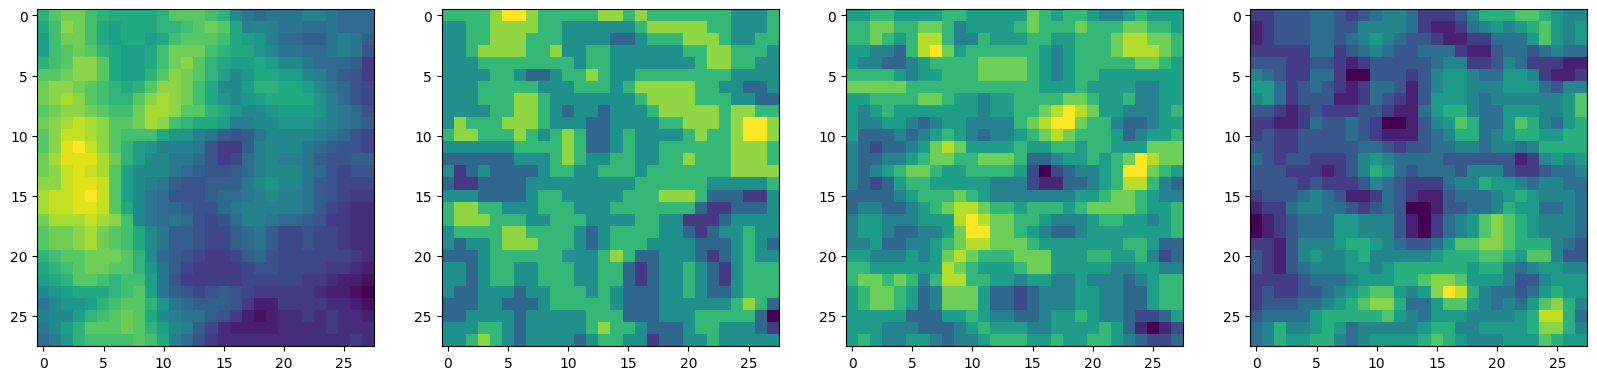

In [13]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample))
    # ax[idx].plot_surface(np.squeeze(sample))

In [14]:
# Scale and return images only
# def scale_images(data):
#     image = data['image'] 
#     return image / 255

In [15]:
# map cache shuffle batch prefetch

# Reload
ds = get_srtm_dataset()
# scale
# ds = ds.map(scale_images)
# cache
ds = ds.cache()
# shuffle
ds = ds.shuffle(60000)
# split into batches
ds = ds.batch(128)
# Reduces likelihood of bottlenecking
ds = ds.prefetch(64)

## Build NN

In [16]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [17]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [18]:
generator = build_generator()

In [19]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [20]:
img = generator.predict(np.random.randn(4, 128, 1))

2023-08-14 18:42:27.580232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-14 18:42:27.598555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 13ms/step


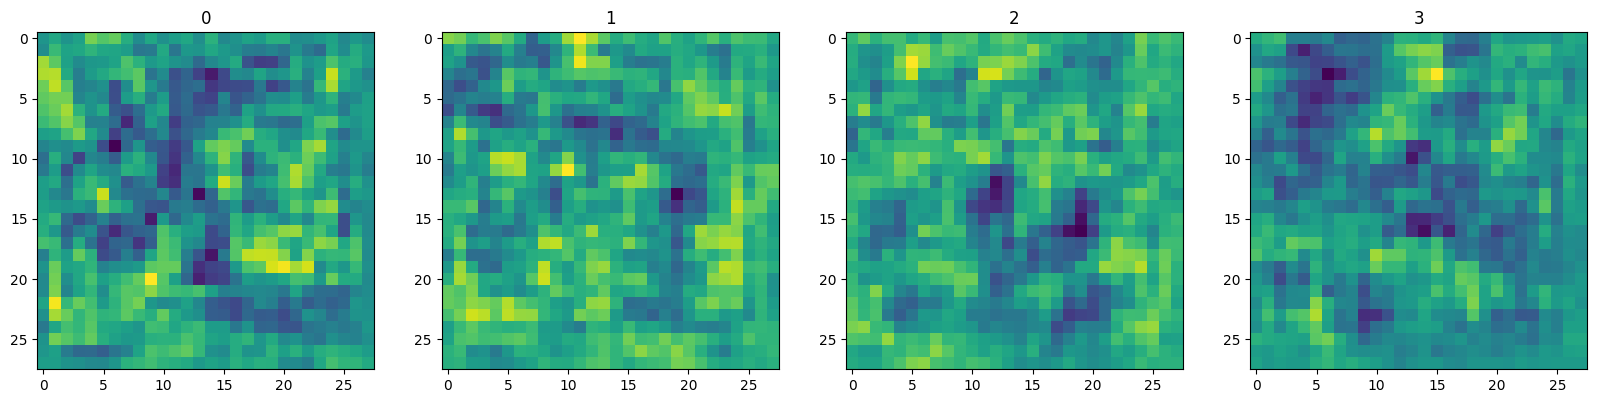

In [21]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [22]:
def build_discriminator():
    model = Sequential()

    # first conv block
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4)) # Might be best to not have
    model.add(Dense(1, activation='sigmoid'))

    return model

In [23]:
discriminator = build_discriminator()

In [24]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [25]:
## Pass generated iamge into discriminator to prototype ;)
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 184ms/step


array([[0.509327]], dtype=float32)

# 4. Construct training loop

# 4.1 Setup losses and optimizers

In [26]:
# Optimizer for both
from tensorflow.keras.optimizers import Adam
# Loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [27]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# 4.2 Subclass model

In [28]:
# Import base model class to subclass our training step
from tensorflow.keras.models import Model

In [29]:
# 3 key functions

class TerrainTileGan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass to base class
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen end disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        ## Compile w/ baseclass
        super().compile(*args, **kwargs)

        # Attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # get the data
        real_images = batch
        # 128 because we start with a linear layer w/ 128 neurons. Gets reshaped lated
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

        # Train discriminator
        with tf.GradientTape() as d_tape:
            # 1. pass real and fake imgs to discriminaotr
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # 2. cresate labels for real and fakes
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # 3. add noise to output to avoid learning too fast
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            ## Not sure if - is good idea.
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # 4. Calculate loss - BINARYCROSSENTROPY
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # 5. Backpropagate -- nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train gen
        with tf.GradientTape() as g_tape:
            # Generate new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss (rewared when disc says fake is real - hence zeros)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            # No need to pass real images bc we're not training discriminator

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss": total_g_loss}
            
    # Also option for train_test

In [30]:
## Alt
# @tf.function
# def train_step():
#     pass

In [31]:
# Create instance of subclassed model
terrainTileGan = TerrainTileGan(generator, discriminator)

In [32]:
# Compile model
terrainTileGan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build callback

In [33]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [34]:
## Create images dir for model
!mkdir -p images

In [35]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## Train

In [36]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Cresate checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verboxe=1)

In [40]:
## Recomended 2000
## fashiongan.load_weights(checkpoint_path)
hist = terrainTileGan.fit(ds, epochs=500, callbacks=[ModelMonitor(), cp_callback])

Epoch 1/500


4/4 [==============================] - 0s 122ms/step - d_loss: 0.5120 - g_loss: 0.7441
Epoch 2/500
4/4 [==============================] - 0s 117ms/step - d_loss: 0.5100 - g_loss: 0.7519
Epoch 3/500
4/4 [==============================] - 0s 118ms/step - d_loss: 0.5083 - g_loss: 0.7612
Epoch 4/500
4/4 [==============================] - 0s 117ms/step - d_loss: 0.5080 - g_loss: 0.7721
Epoch 5/500
4/4 [==============================] - 1s 375ms/step - d_loss: 0.5007 - g_loss: 0.7851
Epoch 6/500
4/4 [==============================] - 0s 116ms/step - d_loss: 0.4963 - g_loss: 0.8004
Epoch 7/500
4/4 [==============================] - 0s 121ms/step - d_loss: 0.4877 - g_loss: 0.8185
Epoch 8/500
4/4 [==============================] - 0s 117ms/step - d_loss: 0.4835 - g_loss: 0.8398
Epoch 9/500
4/4 [==============================] - 0s 119ms/step - d_loss: 0.4753 - g_loss: 0.8650
Epoch 10/500
4/4 [==============================] - 0s 121ms/step - d_loss: 0.4733 - g_loss: 0.8948
Epoch 11/500
4/4 [===

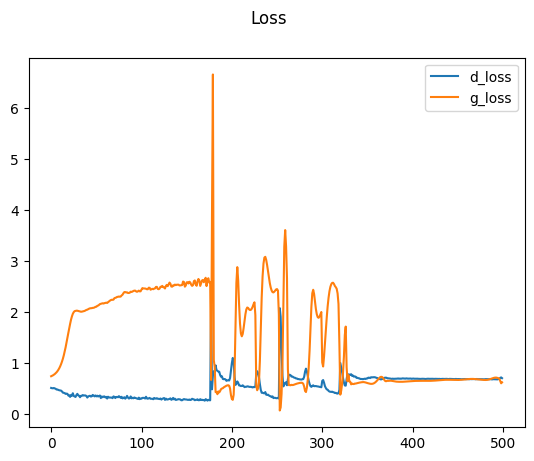

In [41]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

##  5. Test out generator

### 5.1 Generate Images

In [46]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 13ms/step


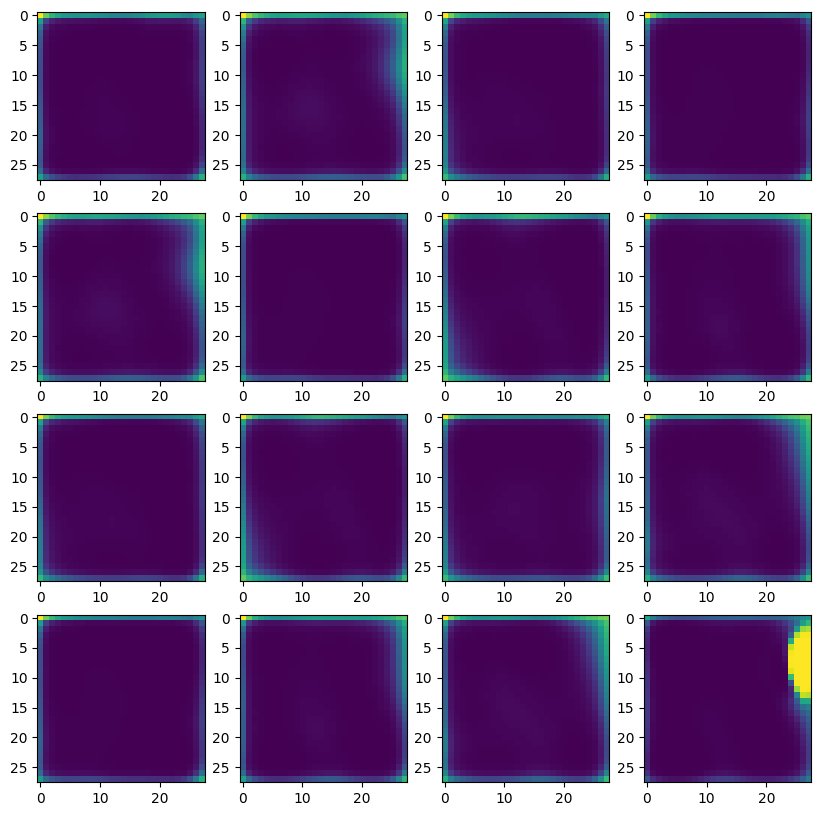

In [47]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
